In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-t7fabecf
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-t7fabecf
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [2]:
!git clone https://github.com/ndb796/StyleCLIP-Tutorial
%cd StyleCLIP-Tutorial

fatal: destination path 'StyleCLIP-Tutorial' already exists and is not an empty directory.


/home/rath/timeImage/StyleCLIP-Tutorial


In [ ]:
import torch
from stylegan2.model import Generator

# download model from here: https://drive.google.com/file/d/1vbkldkk7AO3QA4xY9ayJtQewAwOAuEs1/view?usp=drive_link
g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load('sg2-lhq-1024.pt')["g_ema"], strict=False)
# g_ema.load_state_dict(torch.load('/home/rath/timeImage/converted_lhq_config_f.pt')["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()


In [ ]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


#### <b>Losses</b>

In [ ]:
imagenet_templates = [
    'a bad photo of a {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]

part_templates = [
    'the paw of a {}.',
    'the nose of a {}.',
    'the eye of the {}.',
    'the ears of a {}.',
    'an eye of a {}.',
    'the tongue of a {}.',
    'the fur of the {}.',
    'colorful {} fur.',
    'a snout of a {}.',
    'the teeth of the {}.',
    'the {}s fangs.',
    'a claw of the {}.',
    'the face of the {}',
    'a neck of a {}',
    'the head of the {}',
]

imagenet_templates_small = [
    'a photo of a {}.',
    'a rendering of a {}.',
    'a cropped photo of the {}.',
    'the photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a photo of my {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a photo of one {}.',
    'a close-up photo of the {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a good photo of a {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'a photo of the large {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
]

In [ ]:
import clip
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from ..model.TICL import TICL

device = "cuda" if torch.cuda.is_available() else "cpu"
class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity
    
class TICLLoss(torch.nn.Module):
    def __init__(self, model_path):
        super(TICLLoss, self).__init__()
        self.time_clip = TICL()
        self.time_clip.load_state_dict(torch.load(model_path))
        self.time_clip.eval()
        self.time_clip.to(device)
        
    def forward(self, image, time):
        similarity = 1 - self.time_clip(image, time)[0] / 100
        return similarity



* Initialize a random latent vector using a mean latent vector.

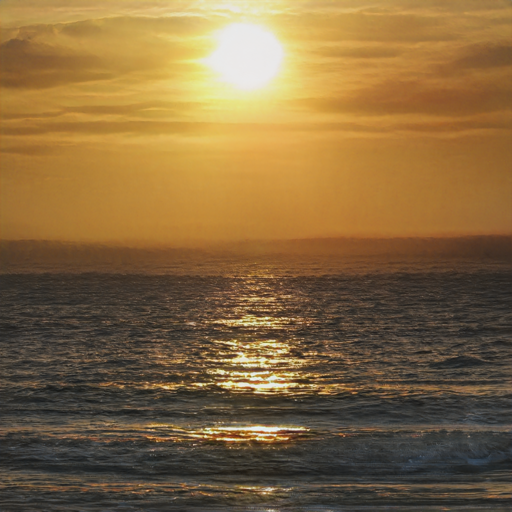

In [44]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage


mean_latent = g_ema.mean_latent(4096)
# print(mean_latent.shape)
latent_code_init_not_trunc = torch.randn(1, 512).cuda()
with torch.no_grad():
    img_orig, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
                                truncation=1.0, truncation_latent=mean_latent)

# Visualize a random latent vector.
image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, padding=0))
h, w = image.size
image.resize((h//2, w//2))

In [ ]:
# NADACLIP LOSS
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np

import math
import clip
from PIL import Image


class DirectionLoss(torch.nn.Module):

    def __init__(self, loss_type='mse'):
        super(DirectionLoss, self).__init__()

        self.loss_type = loss_type

        self.loss_func = {
            'mse':    torch.nn.MSELoss,
            'cosine': torch.nn.CosineSimilarity,
            'mae':    torch.nn.L1Loss
        }[loss_type]()

    def forward(self, x, y):
        if self.loss_type == "cosine":
            return 1. - self.loss_func(x, y)
        
        return self.loss_func(x, y)

class NADACLIPLoss(torch.nn.Module):
    def __init__(self, device, lambda_direction=1., lambda_patch=0., lambda_global=0., lambda_manifold=0., lambda_texture=0., patch_loss_type='mae', direction_loss_type='cosine', clip_model='ViT-B/32'):
        super(NADACLIPLoss, self).__init__()

        self.device = device
        self.model, clip_preprocess = clip.load(clip_model, device=self.device)

        self.clip_preprocess = clip_preprocess
        
        self.preprocess = transforms.Compose([transforms.Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0])] + # Un-normalize from [-1.0, 1.0] (GAN output) to [0, 1].
                                              clip_preprocess.transforms[:2] +                                      # to match CLIP input scale assumptions
                                              clip_preprocess.transforms[4:])                                       # + skip convert PIL to tensor

        self.target_direction      = None
        self.patch_text_directions = None

        self.patch_loss     = DirectionLoss(patch_loss_type)
        self.direction_loss = DirectionLoss(direction_loss_type)
        self.patch_direction_loss = torch.nn.CosineSimilarity(dim=2)

        self.lambda_global    = lambda_global
        self.lambda_patch     = lambda_patch
        self.lambda_direction = lambda_direction
        self.lambda_manifold  = lambda_manifold
        self.lambda_texture   = lambda_texture

        self.src_text_features = None
        self.target_text_features = None
        self.angle_loss = torch.nn.L1Loss()

        self.model_cnn, preprocess_cnn = clip.load("RN50", device=self.device)
        self.preprocess_cnn = transforms.Compose([transforms.Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0])] + # Un-normalize from [-1.0, 1.0] (GAN output) to [0, 1].
                                        preprocess_cnn.transforms[:2] +                                                 # to match CLIP input scale assumptions
                                        preprocess_cnn.transforms[4:])                                                  # + skip convert PIL to tensor

        self.model.requires_grad_(False)
        self.model_cnn.requires_grad_(False)

        self.texture_loss = torch.nn.MSELoss()

    def tokenize(self, strings: list):
        return clip.tokenize(strings).to(self.device)

    def encode_text(self, tokens: list) -> torch.Tensor:
        return self.model.encode_text(tokens)

    def encode_images(self, images: torch.Tensor) -> torch.Tensor:
        images = self.preprocess(images).to(self.device)
        return self.model.encode_image(images)

    def encode_images_with_cnn(self, images: torch.Tensor) -> torch.Tensor:
        images = self.preprocess_cnn(images).to(self.device)
        return self.model_cnn.encode_image(images)
    
    def distance_with_templates(self, img: torch.Tensor, class_str: str, templates=imagenet_templates) -> torch.Tensor:

        text_features  = self.get_text_features(class_str, templates)
        image_features = self.get_image_features(img)

        similarity = image_features @ text_features.T

        return 1. - similarity
    
    def get_text_features(self, class_str: str, templates=imagenet_templates, norm: bool = True) -> torch.Tensor:
        template_text = self.compose_text_with_templates(class_str, templates)

        tokens = clip.tokenize(template_text).to(self.device)

        text_features = self.encode_text(tokens).detach()

        if norm:
            text_features /= text_features.norm(dim=-1, keepdim=True)

        return text_features

    def get_image_features(self, img: torch.Tensor, norm: bool = True) -> torch.Tensor:
        image_features = self.encode_images(img)
        
        if norm:
            image_features /= image_features.clone().norm(dim=-1, keepdim=True)

        return image_features

    def compute_text_direction(self, source_class: str, target_class: str) -> torch.Tensor:
        source_features = self.get_text_features(source_class)
        target_features = self.get_text_features(target_class)

        text_direction = (target_features - source_features).mean(axis=0, keepdim=True)
        text_direction /= text_direction.norm(dim=-1, keepdim=True)

        return text_direction

    def compute_img2img_direction(self, source_images: torch.Tensor, target_images: list) -> torch.Tensor:
        with torch.no_grad():

            src_encoding = self.get_image_features(source_images)
            src_encoding = src_encoding.mean(dim=0, keepdim=True)

            target_encodings = []
            for target_img in target_images:
                
                preprocessed = self.clip_preprocess(Image.open(target_img)).unsqueeze(0).to(self.device)
                
                encoding = self.model.encode_image(preprocessed)
                encoding /= encoding.norm(dim=-1, keepdim=True)

                target_encodings.append(encoding)
            
            target_encoding = torch.cat(target_encodings, axis=0)
            target_encoding = target_encoding.mean(dim=0, keepdim=True)

            direction = target_encoding - src_encoding
            direction /= direction.norm(dim=-1, keepdim=True)

        return direction

    def set_text_features(self, source_class: str, target_class: str) -> None:
        source_features = self.get_text_features(source_class).mean(axis=0, keepdim=True)
        self.src_text_features = source_features / source_features.norm(dim=-1, keepdim=True)

        target_features = self.get_text_features(target_class).mean(axis=0, keepdim=True)
        self.target_text_features = target_features / target_features.norm(dim=-1, keepdim=True)

    def clip_angle_loss(self, src_img: torch.Tensor, source_class: str, target_img: torch.Tensor, target_class: str) -> torch.Tensor:
        if self.src_text_features is None:
            self.set_text_features(source_class, target_class)

        cos_text_angle = self.target_text_features @ self.src_text_features.T
        text_angle = torch.acos(cos_text_angle)

        src_img_features = self.get_image_features(src_img).unsqueeze(2)
        target_img_features = self.get_image_features(target_img).unsqueeze(1)

        cos_img_angle = torch.clamp(target_img_features @ src_img_features, min=-1.0, max=1.0)
        img_angle = torch.acos(cos_img_angle)

        text_angle = text_angle.unsqueeze(0).repeat(img_angle.size()[0], 1, 1)
        cos_text_angle = cos_text_angle.unsqueeze(0).repeat(img_angle.size()[0], 1, 1)

        return self.angle_loss(cos_img_angle, cos_text_angle)

    def compose_text_with_templates(self, text: str, templates=imagenet_templates) -> list:
        return [template.format(text) for template in templates]
            
    def clip_directional_loss(self, src_img: torch.Tensor, source_class: str, target_img: torch.Tensor, target_class: str) -> torch.Tensor:

        if self.target_direction is None:
            self.target_direction = self.compute_text_direction(source_class, target_class)

        src_encoding    = self.get_image_features(src_img)
        target_encoding = self.get_image_features(target_img)

        edit_direction = (target_encoding - src_encoding)
        if edit_direction.sum() == 0:
            target_encoding = self.get_image_features(target_img + 1e-6)
            edit_direction = (target_encoding - src_encoding)

        edit_direction /= (edit_direction.clone().norm(dim=-1, keepdim=True))
        
        return self.direction_loss(edit_direction, self.target_direction).mean()

    def global_clip_loss(self, img: torch.Tensor, text) -> torch.Tensor:
        if not isinstance(text, list):
            text = [text]
            
        tokens = clip.tokenize(text).to(self.device)
        image  = self.preprocess(img)

        logits_per_image, _ = self.model(image, tokens)

        return (1. - logits_per_image / 100).mean()

    def random_patch_centers(self, img_shape, num_patches, size):
        batch_size, channels, height, width = img_shape

        half_size = size // 2
        patch_centers = np.concatenate([np.random.randint(half_size, width - half_size,  size=(batch_size * num_patches, 1)),
                                        np.random.randint(half_size, height - half_size, size=(batch_size * num_patches, 1))], axis=1)

        return patch_centers

    def generate_patches(self, img: torch.Tensor, patch_centers, size):
        batch_size  = img.shape[0]
        num_patches = len(patch_centers) // batch_size
        half_size   = size // 2

        patches = []

        for batch_idx in range(batch_size):
            for patch_idx in range(num_patches):

                center_x = patch_centers[batch_idx * num_patches + patch_idx][0]
                center_y = patch_centers[batch_idx * num_patches + patch_idx][1]

                patch = img[batch_idx:batch_idx+1, :, center_y - half_size:center_y + half_size, center_x - half_size:center_x + half_size]

                patches.append(patch)

        patches = torch.cat(patches, axis=0)

        return patches

    def patch_scores(self, img: torch.Tensor, class_str: str, patch_centers, patch_size: int) -> torch.Tensor:

        parts = self.compose_text_with_templates(class_str, part_templates)    
        tokens = clip.tokenize(parts).to(self.device)
        text_features = self.encode_text(tokens).detach()

        patches        = self.generate_patches(img, patch_centers, patch_size)
        image_features = self.get_image_features(patches)

        similarity = image_features @ text_features.T

        return similarity

    def clip_patch_similarity(self, src_img: torch.Tensor, source_class: str, target_img: torch.Tensor, target_class: str) -> torch.Tensor:
        patch_size = 196 #TODO remove magic number

        patch_centers = self.random_patch_centers(src_img.shape, 4, patch_size) #TODO remove magic number
   
        src_scores    = self.patch_scores(src_img, source_class, patch_centers, patch_size)
        target_scores = self.patch_scores(target_img, target_class, patch_centers, patch_size)

        return self.patch_loss(src_scores, target_scores)

    def patch_directional_loss(self, src_img: torch.Tensor, source_class: str, target_img: torch.Tensor, target_class: str) -> torch.Tensor:

        if self.patch_text_directions is None:
            src_part_classes = self.compose_text_with_templates(source_class, part_templates)
            target_part_classes = self.compose_text_with_templates(target_class, part_templates)

            parts_classes = list(zip(src_part_classes, target_part_classes))

            self.patch_text_directions = torch.cat([self.compute_text_direction(pair[0], pair[1]) for pair in parts_classes], dim=0)

        patch_size = 510 # TODO remove magic numbers

        patch_centers = self.random_patch_centers(src_img.shape, 1, patch_size)

        patches = self.generate_patches(src_img, patch_centers, patch_size)
        src_features = self.get_image_features(patches)

        patches = self.generate_patches(target_img, patch_centers, patch_size)
        target_features = self.get_image_features(patches)

        edit_direction = (target_features - src_features)
        edit_direction /= edit_direction.clone().norm(dim=-1, keepdim=True)

        cosine_dists = 1. - self.patch_direction_loss(edit_direction.unsqueeze(1), self.patch_text_directions.unsqueeze(0))

        patch_class_scores = cosine_dists * (edit_direction @ self.patch_text_directions.T).softmax(dim=-1)

        return patch_class_scores.mean()

    def cnn_feature_loss(self, src_img: torch.Tensor, target_img: torch.Tensor) -> torch.Tensor:
        src_features = self.encode_images_with_cnn(src_img)
        target_features = self.encode_images_with_cnn(target_img)

        return self.texture_loss(src_features, target_features)

    def forward(self, src_img: torch.Tensor, source_class: str, target_img: torch.Tensor, target_class: str, texture_image: torch.Tensor = None):
        clip_loss = 0.0

        if self.lambda_global:
            clip_loss += self.lambda_global * self.global_clip_loss(target_img, [f"a {target_class}"])

        if self.lambda_patch:
            clip_loss += self.lambda_patch * self.patch_directional_loss(src_img, source_class, target_img, target_class)

        if self.lambda_direction:
            clip_loss += self.lambda_direction * self.clip_directional_loss(src_img, source_class, target_img, target_class)

        if self.lambda_manifold:
            clip_loss += self.lambda_manifold * self.clip_angle_loss(src_img, source_class, target_img, target_class)

        if self.lambda_texture and (texture_image is not None):
            clip_loss += self.lambda_texture * self.cnn_feature_loss(texture_image, target_img)

        return clip_loss

In [ ]:
from argparse import Namespace


args = Namespace()
args.description = '23:00'
args.lr_rampup = 0.05
args.lr = 0.1
args.step = 100
args.l2_lambda = 0.0005 
args.save_intermediate_image_every = 10
args.results_dir = 'results'

sigma: [1, 16, 256]


In [ ]:
import os
import math
import torchvision
from torch import optim
from tqdm import tqdm

# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp


text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
os.makedirs(args.results_dir, exist_ok=True)

# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent = latent.cuda()
latent.requires_grad = True
model_path = 'BEST_TICL_PATH_HERE'
clip_loss = CLIPLoss()
NADA_loss = NADA()
TICL_loss = TICLLoss(model_path)


# init an one-hot tensor for time
time = torch.zeros(1, 24).cuda()
# set the target time to 21:00
time[0][12] = 1
time = time.cuda()
optimizer = optim.Adam([latent], lr=args.lr)

for i in tqdm(range(args.step)):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr)
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
    # resize img_gen to 1024x1024
    resize = transforms.Resize((1024,1024))
    # resized_img_gen = resize(img_gen)
    resized_img_gen = transform(img_gen)
    c_loss = clip_loss(resized_img_gen, text_inputs) + NADA_loss(resized_img_gen, text_inputs) + TICL_loss(resized_img_gen, time)
    l2_loss = ((latent_code_init - latent) ** 2).sum()
    loss = c_loss + l2_loss * args.l2_lambda
    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    tqdm.write(f"step: {i}, loss: {loss.item()}, c_loss: {c_loss.item()}, l2_loss: {l2_loss.item()}")
    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.png", normalize=True)

with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir, "final_result.jpg"), normalize=True, scale_each=True)

  0%|          | 0/100 [00:00<?, ?it/s]/home/rath/anaconda3/envs/ece598/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s]

step: 0, loss: 1.0348246097564697, c_loss: 1.0348246097564697, l2_loss: 0.0


  1%|          | 1/100 [00:00<00:49,  1.99it/s]

step: 1, loss: 1.0348267555236816, c_loss: 1.0348267555236816, l2_loss: 0.0


  2%|▏         | 2/100 [00:01<00:48,  2.00it/s]

step: 2, loss: 1.0247046947479248, c_loss: 1.0238349437713623, l2_loss: 1.7395398616790771


  3%|▎         | 3/100 [00:01<00:48,  1.99it/s]

step: 3, loss: 1.0170785188674927, c_loss: 1.0119236707687378, l2_loss: 10.309738159179688


  4%|▍         | 4/100 [00:02<00:48,  1.96it/s]

step: 4, loss: 1.02022385597229, c_loss: 1.0073994398117065, l2_loss: 25.64888572692871


  5%|▌         | 5/100 [00:02<00:49,  1.92it/s]

step: 5, loss: 1.030941367149353, c_loss: 1.0054131746292114, l2_loss: 51.05648422241211


  6%|▌         | 6/100 [00:03<00:49,  1.90it/s]

step: 6, loss: 1.0478191375732422, c_loss: 1.0068961381912231, l2_loss: 81.84593963623047


  7%|▋         | 7/100 [00:03<00:49,  1.87it/s]

step: 7, loss: 1.0618886947631836, c_loss: 1.0063683986663818, l2_loss: 111.04058074951172


  8%|▊         | 8/100 [00:04<00:49,  1.86it/s]

step: 8, loss: 1.0701642036437988, c_loss: 1.0030293464660645, l2_loss: 134.26963806152344


  9%|▉         | 9/100 [00:04<00:48,  1.86it/s]

step: 9, loss: 1.0748515129089355, c_loss: 0.9987967610359192, l2_loss: 152.1095428466797


 10%|█         | 10/100 [00:05<00:48,  1.86it/s]

step: 10, loss: 1.0791372060775757, c_loss: 0.9943678379058838, l2_loss: 169.53878784179688


 11%|█         | 11/100 [00:05<00:48,  1.84it/s]

step: 11, loss: 1.0982638597488403, c_loss: 1.003842830657959, l2_loss: 188.84213256835938


 12%|█▏        | 12/100 [00:06<00:47,  1.85it/s]

step: 12, loss: 1.1048461198806763, c_loss: 0.9969621300697327, l2_loss: 215.7679443359375


 13%|█▎        | 13/100 [00:07<00:46,  1.86it/s]

step: 13, loss: 1.1231886148452759, c_loss: 1.0049750804901123, l2_loss: 236.42713928222656


 14%|█▍        | 14/100 [00:07<00:45,  1.88it/s]

step: 14, loss: 1.1263837814331055, c_loss: 0.9979972243309021, l2_loss: 256.77301025390625


 15%|█▌        | 15/100 [00:08<00:44,  1.89it/s]

step: 15, loss: 1.13572359085083, c_loss: 0.9971071481704712, l2_loss: 277.2330017089844


 16%|█▌        | 16/100 [00:08<00:44,  1.90it/s]

step: 16, loss: 1.1353626251220703, c_loss: 0.9866800308227539, l2_loss: 297.36505126953125


 17%|█▋        | 17/100 [00:09<00:43,  1.91it/s]

step: 17, loss: 1.1319843530654907, c_loss: 0.98394775390625, l2_loss: 296.0730895996094


 18%|█▊        | 18/100 [00:09<00:42,  1.92it/s]

step: 18, loss: 1.1362093687057495, c_loss: 0.9860799908638, l2_loss: 300.2587585449219


 19%|█▉        | 19/100 [00:10<00:42,  1.91it/s]

step: 19, loss: 1.1244657039642334, c_loss: 0.9736688137054443, l2_loss: 301.59368896484375


 20%|██        | 20/100 [00:10<00:41,  1.91it/s]

step: 20, loss: 1.121508240699768, c_loss: 0.9714815616607666, l2_loss: 300.0533447265625


 21%|██        | 21/100 [00:11<00:41,  1.92it/s]

step: 21, loss: 1.1129169464111328, c_loss: 0.9649715423583984, l2_loss: 295.89068603515625


 22%|██▏       | 22/100 [00:11<00:40,  1.94it/s]

step: 22, loss: 1.1168512105941772, c_loss: 0.9723297953605652, l2_loss: 289.04278564453125


 23%|██▎       | 23/100 [00:12<00:39,  1.96it/s]

step: 23, loss: 1.1116923093795776, c_loss: 0.9694744348526001, l2_loss: 284.4356689453125


 24%|██▍       | 24/100 [00:12<00:38,  1.97it/s]

step: 24, loss: 1.1126443147659302, c_loss: 0.9758445024490356, l2_loss: 273.599609375


 25%|██▌       | 25/100 [00:13<00:38,  1.97it/s]

step: 25, loss: 1.1057008504867554, c_loss: 0.9758024215698242, l2_loss: 259.79681396484375


 26%|██▌       | 26/100 [00:13<00:38,  1.94it/s]

step: 26, loss: 1.1011344194412231, c_loss: 0.9767095446586609, l2_loss: 248.84982299804688


 27%|██▋       | 27/100 [00:14<00:37,  1.92it/s]

step: 27, loss: 1.0879234075546265, c_loss: 0.9667885303497314, l2_loss: 242.26968383789062


 28%|██▊       | 28/100 [00:14<00:37,  1.94it/s]

step: 28, loss: 1.0990052223205566, c_loss: 0.9793950319290161, l2_loss: 239.2204132080078


 29%|██▉       | 29/100 [00:15<00:36,  1.94it/s]

step: 29, loss: 1.0898816585540771, c_loss: 0.9740475416183472, l2_loss: 231.66818237304688


 30%|███       | 30/100 [00:15<00:35,  1.95it/s]

step: 30, loss: 1.0797924995422363, c_loss: 0.9721195697784424, l2_loss: 215.34585571289062


 31%|███       | 31/100 [00:16<00:35,  1.97it/s]

step: 31, loss: 1.0686815977096558, c_loss: 0.9682291746139526, l2_loss: 200.90478515625


 32%|███▏      | 32/100 [00:16<00:34,  1.98it/s]

step: 32, loss: 1.0669991970062256, c_loss: 0.9724370837211609, l2_loss: 189.12413024902344


 33%|███▎      | 33/100 [00:17<00:34,  1.95it/s]

step: 33, loss: 1.0720032453536987, c_loss: 0.9833074808120728, l2_loss: 177.39154052734375


 34%|███▍      | 34/100 [00:17<00:34,  1.94it/s]

step: 34, loss: 1.070831537246704, c_loss: 0.9881969690322876, l2_loss: 165.26910400390625


 35%|███▌      | 35/100 [00:18<00:33,  1.92it/s]

step: 35, loss: 1.0660243034362793, c_loss: 0.9863352179527283, l2_loss: 159.37826538085938


 36%|███▌      | 36/100 [00:18<00:33,  1.92it/s]

step: 36, loss: 1.0508356094360352, c_loss: 0.971805214881897, l2_loss: 158.06085205078125


 37%|███▋      | 37/100 [00:19<00:32,  1.91it/s]

step: 37, loss: 1.0528457164764404, c_loss: 0.9733539819717407, l2_loss: 158.98345947265625


 38%|███▊      | 38/100 [00:19<00:32,  1.91it/s]

step: 38, loss: 1.0542075634002686, c_loss: 0.9732928276062012, l2_loss: 161.829345703125


 39%|███▉      | 39/100 [00:20<00:31,  1.92it/s]

step: 39, loss: 1.063812494277954, c_loss: 0.9804360866546631, l2_loss: 166.7527313232422


 40%|████      | 40/100 [00:20<00:31,  1.93it/s]

step: 40, loss: 1.0500919818878174, c_loss: 0.9651258587837219, l2_loss: 169.93212890625


 41%|████      | 41/100 [00:21<00:30,  1.92it/s]

step: 41, loss: 1.0507148504257202, c_loss: 0.9637402296066284, l2_loss: 173.94912719726562


 42%|████▏     | 42/100 [00:21<00:29,  1.94it/s]

step: 42, loss: 1.0579942464828491, c_loss: 0.9685047268867493, l2_loss: 178.97901916503906


 43%|████▎     | 43/100 [00:22<00:29,  1.95it/s]

step: 43, loss: 1.0554838180541992, c_loss: 0.964273989200592, l2_loss: 182.419677734375


 44%|████▍     | 44/100 [00:23<00:28,  1.95it/s]

step: 44, loss: 1.061100721359253, c_loss: 0.9695810079574585, l2_loss: 183.03948974609375


 45%|████▌     | 45/100 [00:23<00:28,  1.96it/s]

step: 45, loss: 1.0566325187683105, c_loss: 0.9648294448852539, l2_loss: 183.60626220703125


 46%|████▌     | 46/100 [00:24<00:27,  1.97it/s]

step: 46, loss: 1.0413936376571655, c_loss: 0.9498178958892822, l2_loss: 183.15151977539062


 47%|████▋     | 47/100 [00:24<00:26,  1.97it/s]

step: 47, loss: 1.0538625717163086, c_loss: 0.9626250863075256, l2_loss: 182.47506713867188


 48%|████▊     | 48/100 [00:25<00:26,  1.97it/s]

step: 48, loss: 1.048114538192749, c_loss: 0.9581663608551025, l2_loss: 179.89646911621094


 49%|████▉     | 49/100 [00:25<00:25,  1.97it/s]

step: 49, loss: 1.044739842414856, c_loss: 0.9564520120620728, l2_loss: 176.57566833496094


 50%|█████     | 50/100 [00:26<00:25,  1.96it/s]

step: 50, loss: 1.0412746667861938, c_loss: 0.9552016854286194, l2_loss: 172.14585876464844


 51%|█████     | 51/100 [00:26<00:25,  1.95it/s]

#### <b>Result Visualization</b>

In [ ]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, padding=0))
h, w = result_image.size
result_image.resize((h//2, w//2))

In [13]:
!ffmpeg -r 15 -i results/%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p sun_l2_loss_out_2000_landscape_100steps.mp4
# print mp4 path

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
!rm -rf results